# Notes

Use state-level version of ensemble (once Xiao uploads them)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [79]:
DEATH_DATE = '4/3/2020' 
ENSEMBLE_FILE = "./yugroup/03_31.csv"
IHME_FILE = "./ihme/2020-03-31.csv"

PROJECTION_DATE = '4/3/2020'

## Read in

In [80]:
## Import the Data and Predictions
deaths_true = pd.read_csv("../../data/usafacts/deaths.csv")

## Add transpose step
deaths_true = deaths_true.T
deaths_true = deaths_true.rename(columns=deaths_true.iloc[0]).drop(deaths_true.index[0])

## Getting the columns we want
deaths_true[DEATH_DATE] = deaths_true[DEATH_DATE].astype('float')
deaths_true = deaths_true[["State", DEATH_DATE]].groupby("State")\
    .agg( {DEATH_DATE:  'sum'}).reset_index().rename(columns={"State": "state", DEATH_DATE: "deaths"})

# predictions
deaths_pred = pd.read_csv(ENSEMBLE_FILE)
deaths_pred = deaths_pred[deaths_pred["state"] != "US"]

# IHME predictions
deaths_ihme = pd.read_csv(IHME_FILE)
filtered_cols = ["Other Counties, WA", "US","King and Snohomish Counties (excluding Life Care Center), WA",
                                               "Life Care Center, Kirkland, WA"]
deaths_ihme = \
    deaths_ihme[~deaths_ihme["location"].isin(filtered_cols)]
deaths_ihme["state"] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT",  "DE", "DC","FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"] 
deaths_ihme = deaths_ihme[["state", "3_day_cumul_mean"]].rename(columns={"3_day_cumul_mean": "3_day_mean"})

In [81]:
### PROCESS THE MODEL WE WANT HERE
deaths_pred = deaths_pred[["state", "predicted_deaths_ensemble_3"]]
# deaths_pred = deaths_pred[["state", "predicted_deaths_simple_ensemble_3"]]\
#     .rename(columns={"predicted_deaths_simple_ensemble_3": "predicted_deaths_ensemble_3"})

In [82]:
# Dataframe of Truth and Lies (Predictions)
df = deaths_true.merge(deaths_pred, how="left", on="state")\
    .merge(deaths_ihme, how="left", on="state")

## Losses

In [83]:
## Let's Compute some losses

# L1 Loss
df = df.assign(l1_ours=lambda x: np.abs(x.deaths - x.predicted_deaths_ensemble_3))
df = df.assign(l1_theirs = lambda x: np.abs(x.deaths - x["3_day_mean"]))

# L2 Loss
df = df.assign(l2_ours=lambda x: (x.deaths - x.predicted_deaths_ensemble_3)**2)
df = df.assign(l2_theirs = lambda x: (x.deaths - x["3_day_mean"])**2)

# Log L1 Loss
df = df.assign(l1_log_ours=lambda x: np.log(np.abs(x.deaths - x.predicted_deaths_ensemble_3) + 1))
df = df.assign(l1_log_theirs = lambda x: np.log(np.abs(x.deaths - x["3_day_mean"]) + 1))

# Log L2 Loss
df = df.assign(l2_log_ours=lambda x: np.log((x.deaths - x.predicted_deaths_ensemble_3)**2 + 1))
df = df.assign(l2_log_theirs = lambda x: np.log((x.deaths - x["3_day_mean"])**2 + 1))


## Compute the Results
res_cols = ["l1_ours", "l1_theirs", 
           "l2_ours", "l2_theirs",
            "l1_log_ours", "l1_log_theirs",
           "l2_log_ours", "l2_log_theirs"]
res = df[res_cols]

res.agg("sum")

l1_ours            2231.316844
l1_theirs          1298.922000
l2_ours          385718.308306
l2_theirs        372008.394670
l1_log_ours         153.960082
l1_log_theirs       105.543153
l2_log_ours         299.465265
l2_log_theirs       196.872374
dtype: float64

## Plots for log space

[Text(0, 0.5, 'IHME Model 3 Day Mean'),
 Text(0.5, 0, '(Log) Number of Deaths per State on 4/3/2020')]

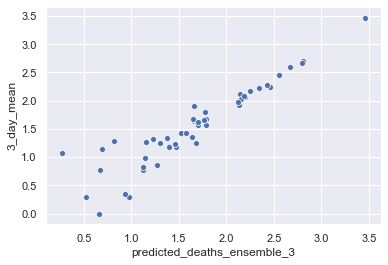

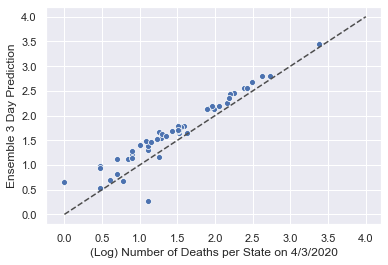

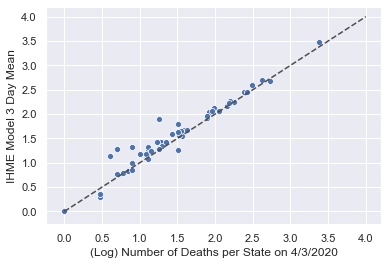

In [84]:
## Scatter Plots
# Log Transform since idk seaborn
plt_df = np.log10(df[["deaths"]] + 1)
plt_df["predicted_deaths_ensemble_3"] = np.log10(df["predicted_deaths_ensemble_3"] + 1)
plt_df["3_day_mean"] = np.log10(df["3_day_mean"] + 1)


# Our Preds -- Their Preds
f, ax = plt.subplots()
sns.scatterplot(x = "predicted_deaths_ensemble_3", y="3_day_mean", data=plt_df)

# Our Preds -- Real Data
f, ax = plt.subplots()
ax.plot([0, 4],[0,4], 
                        ls="--", c=".3")
sns.scatterplot(x = "deaths", y="predicted_deaths_ensemble_3", data=plt_df)
ax.set(ylabel="Ensemble 3 Day Prediction",
      xlabel="(Log) Number of Deaths per State on " + PROJECTION_DATE)

# Their Preds Real Data
f, ax = plt.subplots()
ax.plot([0,4],[0, 4], 
                        ls="--", c=".3")
sns.scatterplot(x = "deaths", y="3_day_mean", data=plt_df)
ax.set(ylabel="IHME Model 3 Day Mean",
      xlabel="(Log) Number of Deaths per State on " + PROJECTION_DATE)

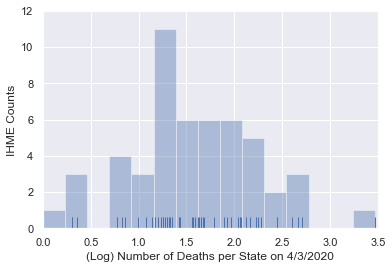

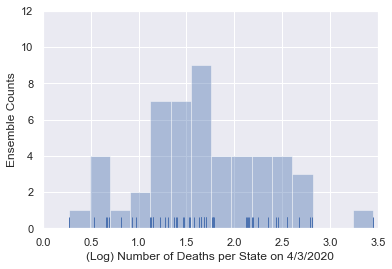

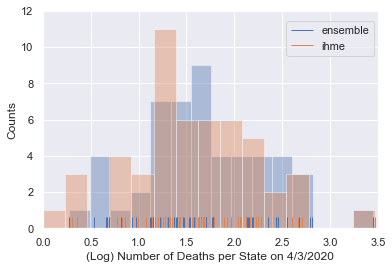

In [85]:
## Histograms
f, ax = plt.subplots()
sns.distplot(plt_df['3_day_mean'], kde=False, rug=True, bins = 15);
ax.set(ylabel="IHME Counts",
      xlabel="(Log) Number of Deaths per State on " + PROJECTION_DATE)
ax.set(xlim=(0, 3.5), ylim=(0,12))

f, ax = plt.subplots()
sns.distplot(plt_df['predicted_deaths_ensemble_3'], kde=False, rug=True, bins = 15);
ax.set(ylabel="Ensemble Counts",
      xlabel="(Log) Number of Deaths per State on " + PROJECTION_DATE)
ax.set(xlim=(0, 3.5), ylim=(0,12))

f, ax = plt.subplots()
sns.distplot(plt_df['predicted_deaths_ensemble_3'], kde=False, rug=True, bins = 15);
ax.set(ylabel="Ensemble Counts",
      xlabel="(Log) Number of Deaths per State on " + PROJECTION_DATE)
ax.set(xlim=(0, 3.5), ylim=(0,12))

sns.distplot(plt_df['3_day_mean'], kde=False, rug=True, bins = 15);
ax.set(ylabel="Counts",
      xlabel="(Log) Number of Deaths per State on " + PROJECTION_DATE)

f.legend(loc='center left', labels=['ensemble','ihme'], bbox_to_anchor=(0.65, 0.8), ncol=1)

## Plots for non-log

[Text(0, 0.5, 'IHME Model 3 Day Mean'),
 Text(0.5, 0, 'Number of Deaths per State on 4/3/2020')]

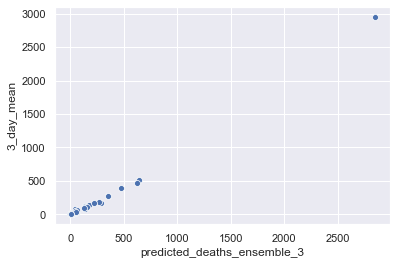

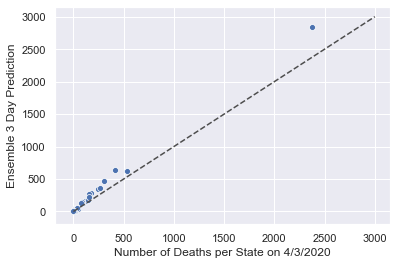

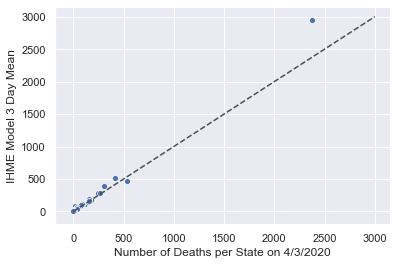

In [86]:
## Scatter Plots
# plt_df = np.log10(df[["deaths"]] + 1)
# plt_df["predicted_deaths_ensemble_3"] = np.log10(df["predicted_deaths_ensemble_3"] + 1)
# plt_df["3_day_mean"] = np.log10(df["3_day_mean"] + 1)

## Scatter Plots
# Log Transform since idk seaborn
plt_df = df

# Our Preds -- Their Preds
f, ax = plt.subplots()
sns.scatterplot(x = "predicted_deaths_ensemble_3", y="3_day_mean", data=plt_df)

# Our Preds -- Real Data
f, ax = plt.subplots()
ax.plot([0, 3000],[0,3000], 
                        ls="--", c=".3")
sns.scatterplot(x = "deaths", y="predicted_deaths_ensemble_3", data=plt_df)
ax.set(ylabel="Ensemble 3 Day Prediction",
      xlabel="Number of Deaths per State on " + PROJECTION_DATE)

# Their Preds Real Data
f, ax = plt.subplots()
ax.plot([0,3000],[0, 3000], 
                        ls="--", c=".3")
sns.scatterplot(x = "deaths", y="3_day_mean", data=plt_df)
ax.set(ylabel="IHME Model 3 Day Mean",
      xlabel="Number of Deaths per State on " + PROJECTION_DATE)